## Exp 10: ACGAN
### use classifier

In [1]:
from __future__ import print_function
from __future__ import absolute_import
import matplotlib.pyplot as plt

import sugartensor as tf
import os
from IPython.display import display, Image
import numpy as np
from scipy import ndimage
from six.moves import cPickle as pickle

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"
%matplotlib inline


In [2]:
batch_size = 100   # batch size
image_size = 64
pixel_depth = 255.0
noise_length = 100
directory = 'pureTensorflowExp/Exp10/'
if not os.path.exists(directory):
    os.makedirs(directory)

## Training data

-9.15708528646
15000
9.0


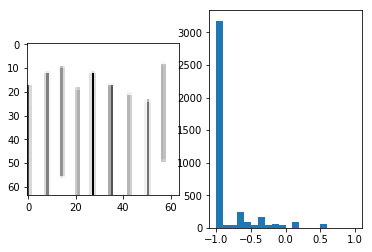

In [3]:
dir= "barcode/train/"
fn = os.listdir(dir)
total = len(fn)
total
#     change the range to switch between exp2 : [0, 1, 2, 3, 4, 5, 6]
#     and exp2.1: [1, 3, 5, 7, 9]
visible = [1, 3, 5, 7, 9]
train_size = 3000*len(visible)
# put all the images into this blob of size total*size*size*1
# REMEMBER to change shape of dataset
training_dataset = np.ndarray(shape = (train_size, image_size, image_size, 1), dtype = np.float32)
counter = 0
# REMEMBER to change shape of training label
training_label = np.ndarray(shape = (train_size), dtype = np.float32)
for file in fn:
    # because the output of G is tanh (-1 to 1) so input images should also be between -1 and 1
    image_data = (ndimage.imread(dir+file).astype(float) - 255/2) / (pixel_depth/2)
    label = int(file.split("_")[0])
    if label in visible:
        training_label[counter] = label
        training_dataset[counter, :, :] = image_data[:,:,0].reshape(image_size, image_size, 1)
        counter+=1
#     else:
#         print(file[0])
# shuffle dataset
permutation = np.random.permutation(counter)
training_dataset = training_dataset[permutation,:,:,:]
training_label = training_label[permutation]


print(np.sum(training_dataset)/(300*len(visible)*image_size*image_size))
print(len(training_label))
%matplotlib inline

# We'll show the image and its pixel value histogram side-by-side.
_, (ax1, ax2) = plt.subplots(1, 2)

# To interpret the values as a 28x28 image, we need to reshape
# the numpy array, which is one dimensional.
image = training_dataset[100]
print(training_label[100])
ax1.imshow(image.reshape(image_size, image_size), cmap=plt.cm.Greys);

ax2.hist(image.reshape(image_size*image_size), bins=20, range=[-1, 1]);

# Helper layers

In [4]:
def print_variable():
    for v in tf.global_variables():
        print(v)
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)
def leaky_relu(input, leaky_slope = 0.2):
    return tf.maximum(input, leaky_slope*input)

def flatten(input):
    return tf.contrib.layers.flatten(input)
    
# capping stddev at 0.1 is important to avoid exploding value
def conv(input, kernel_size, stride, out_dim, activation = 'leaky_relu', name = 'conv', use_bn = True):
    with tf.variable_scope(name):
        weights = tf.get_variable("weights", 
                                  [kernel_size, kernel_size, input.get_shape()[-1], out_dim],
                                  initializer=tf.truncated_normal_initializer(stddev=0.02))
        biases = tf.get_variable("biases", [out_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.nn.conv2d(input, weights, strides = [1, stride, stride, 1], padding = 'SAME')
        hidden = biases+conv
        if use_bn:
            hidden = batch_norm(hidden)
        if activation=='relu':
            return tf.nn.relu(hidden)
        if activation=='leaky_relu':
            return leaky_relu(hidden)
        if activation=='tanh':
            return tf.tanh(hidden)
        if activation=='sigmoid':
            return tf.sigmoid(hidden)
# out_shape has the shape [batch_size, out_height, out_width, channel]
# NOTICE: kernel_shape has the shape [h, w, OUT_channel, IN_channel] (reverse from normal conv)
def deconv(input, kernel_size, stride, out_shape, activation = 'relu', name='deconv', use_bn = True):
    with tf.variable_scope(name):
        weights = tf.get_variable("weights", 
                                  [kernel_size, kernel_size, out_shape[-1], input.get_shape()[-1]], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.02))
        biases = tf.get_variable("biases", [out_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.nn.conv2d_transpose(input, weights, out_shape, strides = [1, stride, stride, 1], padding = 'SAME')
        hidden = biases+deconv
        if use_bn:
            hidden = batch_norm(hidden)
        if activation=='relu':
            return tf.nn.relu(hidden)
        if activation=='leaky_relu':
            return leaky_relu(hidden)
        if activation=='tanh':
            return tf.tanh(hidden)
        if activation=='sigmoid':
            return tf.sigmoid(hidden)

def batch_norm(input, epsilon=1e-5, decay = 0.9, name = "batch_norm", is_training = True):
    with tf.variable_scope(name):
        return tf.contrib.layers.batch_norm(input,
                      decay=decay, 
                      updates_collections=None,
                      epsilon=epsilon,
                      scale=True,
                      is_training=is_training,
                      )

def fully_connected(input, out_shape, name='fc'):
    with tf.variable_scope(name):
        input_shape = input.get_shape().as_list()
        batch = input_shape[0]
        flattened_size = input_shape[1]
        weights = tf.get_variable("weights", [flattened_size, out_shape], 
                                  initializer=tf.random_normal_initializer(stddev=0.02))
        biases = tf.get_variable("biases", [out_shape],
                                initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, weights) + biases

In [5]:
# input noises has the shape [batch_size, noises_length]
# noises has length equal class+pure_noise
# e.g if using one hot encoding for 10 classes and 100 pure noises, 
# noises_length = 110. noises_length = 101 if use regression
def Generator(input_noises, name = "G"):
    with tf.variable_scope(name):
        tmp = fully_connected(input_noises, 4* 4* 1024, name = 'linear1')
        linear1 = batch_norm(tf.reshape(tmp, [batch_size, 4, 4, 1024]))
        deconv1 = deconv(linear1, kernel_size=5, stride = 2, out_shape = [batch_size, 8, 8, 512], name='deconv1')
        deconv2 = deconv(deconv1, kernel_size=5, stride = 2, out_shape = [batch_size, 16, 16, 256], name='deconv2')
        deconv3 = deconv(deconv2, kernel_size=5, stride = 2, out_shape = [batch_size, 32, 32, 128], name = 'deconv3')
        output = deconv(deconv3, kernel_size=5, stride = 2, out_shape = [batch_size, 64, 64, 1], activation = 'tanh', name = 'output', use_bn=False)

        return output

# images has the shape [batch_size, image_width, image_height, 1]
def Discriminator(images, name = "D", reuse = False):
    with tf.variable_scope(name, reuse = reuse):
        conv0 = conv(images, kernel_size=5, stride=2, out_dim=64, name = 'conv0', use_bn= False)
        conv1 = conv(conv0 , kernel_size=5, stride=2, out_dim=128, name = 'conv1')
        conv2 = conv(conv1 , kernel_size=5, stride=2, out_dim=256, name = 'conv2')
        conv3 = conv(conv2 , kernel_size=3, stride=1, out_dim=512, name = 'conv3')
        #classifier
#         values = fully_connected(flatten(conv6), 1, name = 'value')
        #discriminator
        h4 = fully_connected(flatten(conv3), 1, name = 'truefalse')
        return h4


# Unit Test

Tensor("G_unit_test/output/Tanh:0", shape=(100, 64, 64, 1), dtype=float32)


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Generator test is passed
fake_images shape: Tensor("D_unit_test/truefalse/add:0", shape=(100, 1), dtype=float32)
a: [[  1.36465526e+00]
 [  1.32903948e-01]
 [ -3.32365584e+00]
 [ -8.25394690e-01]
 [ -2.35346675e+00]
 [  2.77222693e-02]
 [ -1.48409951e+00]
 [ -1.82183039e+00]
 [ -1.27207434e+00]
 [ -1.24345207e+00]
 [ -3.64414120e+00]
 [ -2.01950741e+00]
 [ -1.96655107e+00]
 [ -2.30876541e+00]
 [ -1.26016617e+00]
 [ -1.98233867e+00]
 [ -3.04881978e+00]
 [ -5.13193250e-01]
 [ -1.75922990e+00]
 [ -1.59316003e+00]
 [ -3.63599443e+00]
 [  2.26869762e-01]
 [ -8.71606171e-01]
 [ -1.01120341e+00]
 [ -3.29527760e+00]
 [ -2.15589142e+00]
 [ -2.18054581e+00]
 [ -1.14720845e+00]
 [ -2.20607686e+00]
 [ -4.26854730e-01]
 [ -1.79217923e+00]
 [ -3.30238128e+00]
 [  4.28580284e-01]
 [  7.64301538e-01]
 [ -5.46399415e-01]
 [ -8.18943679e-02]
 [ -6.93760037e-01]
 [ -1.12547052e+00]
 [  4.41680998e-02]
 [  2.87497044e-03]
 [ -7.63912261e-01]
 [  3.13407707e+00]
 [ -3.54180813e+00]
 [ -1.63298941e+00]
 [ -

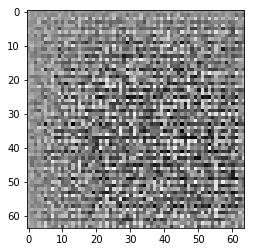

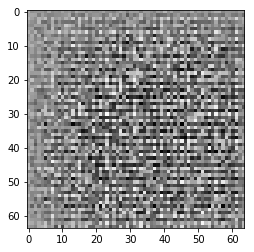

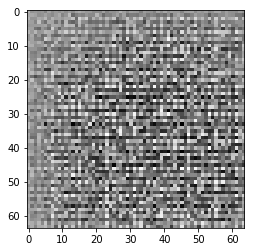

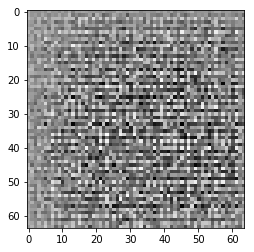

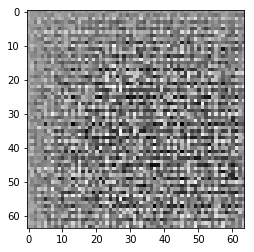

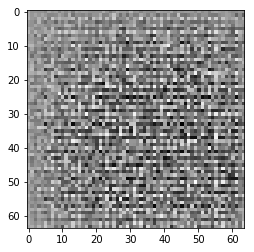

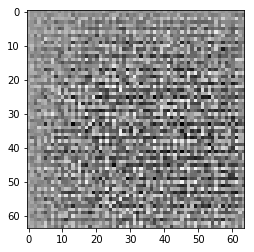

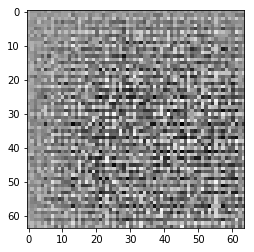

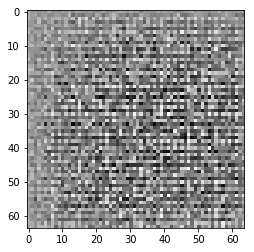

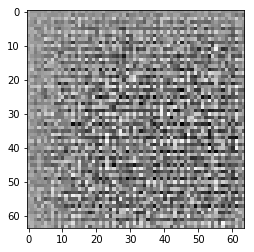

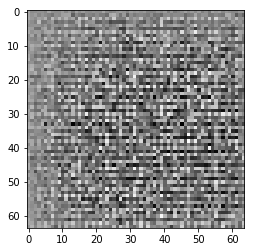

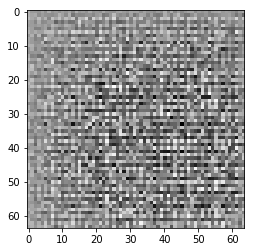

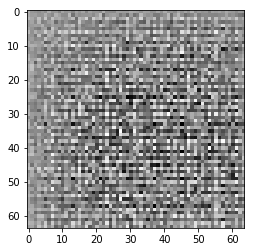

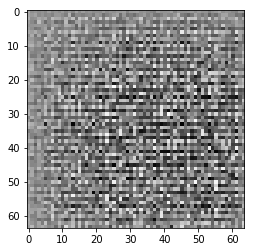

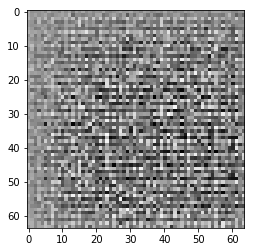

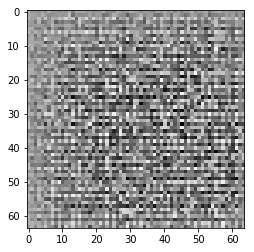

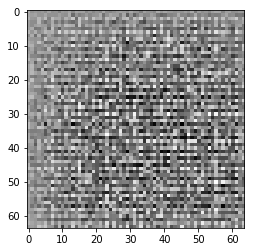

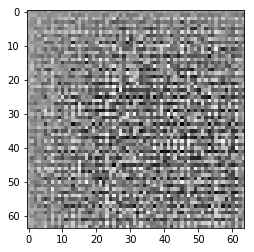

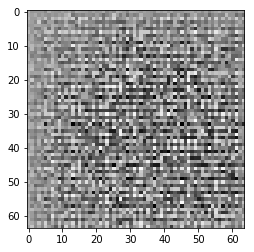

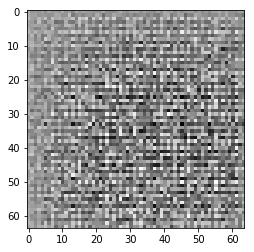

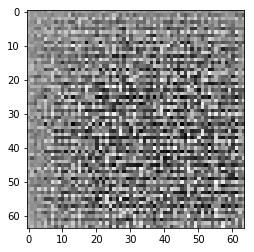

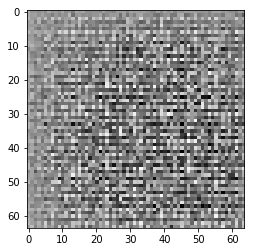

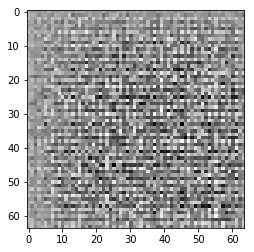

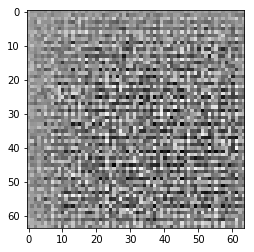

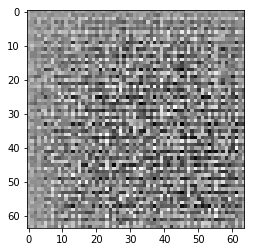

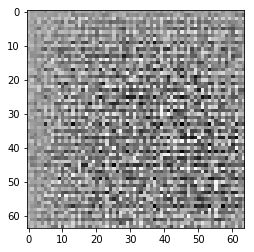

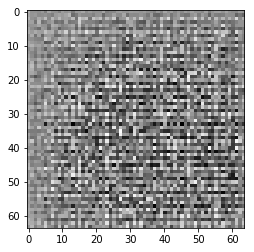

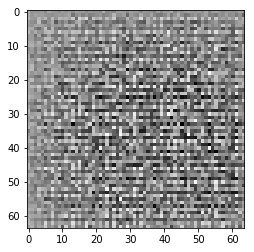

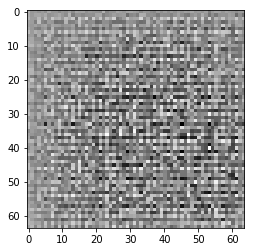

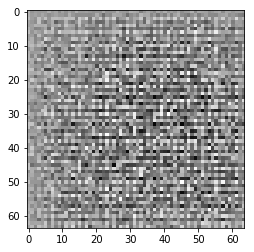

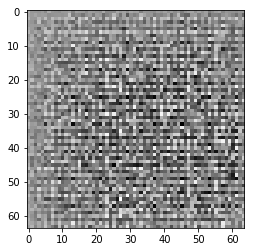

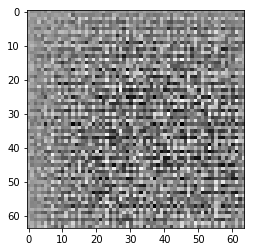

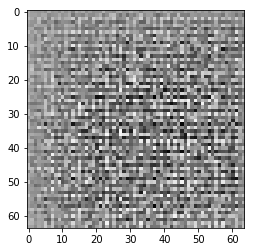

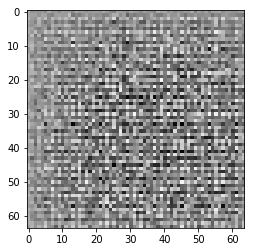

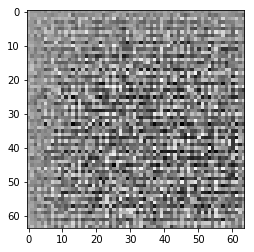

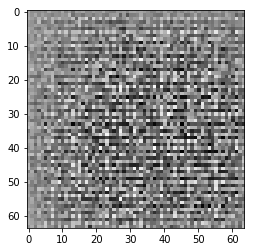

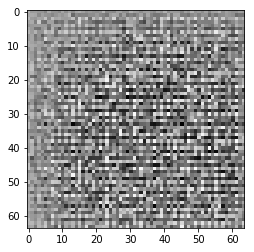

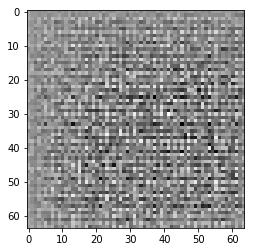

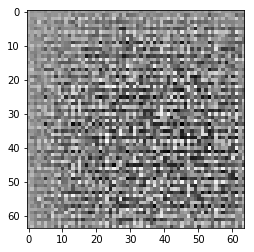

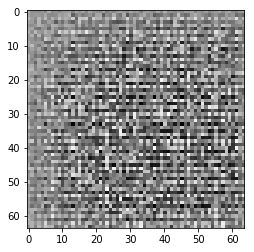

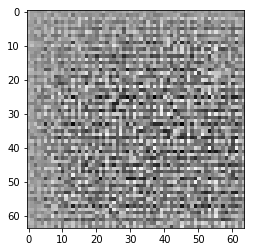

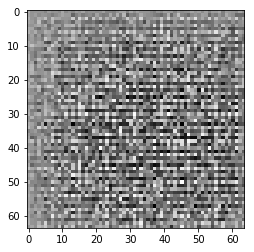

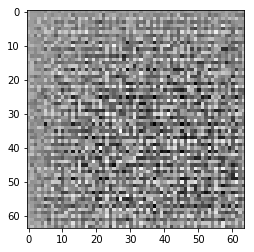

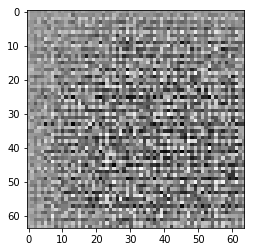

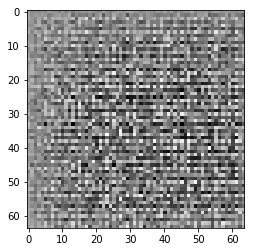

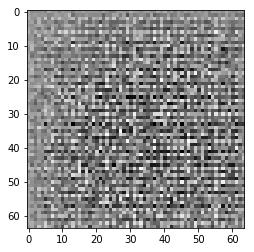

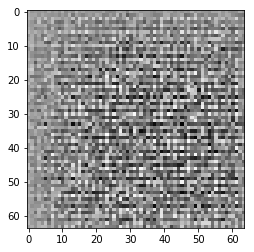

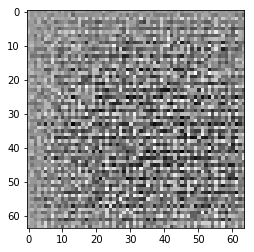

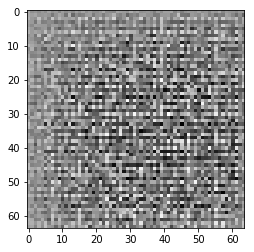

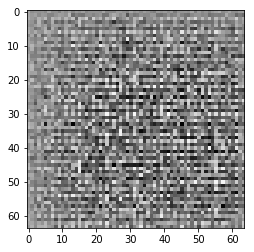

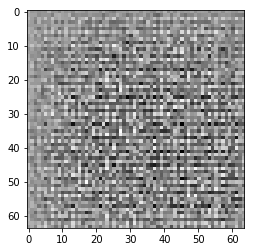

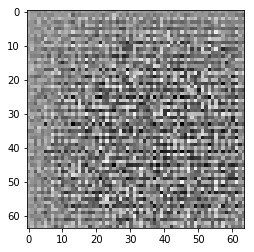

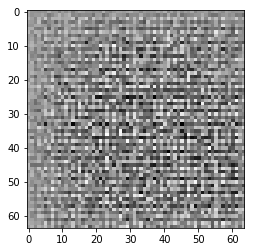

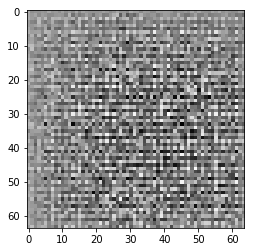

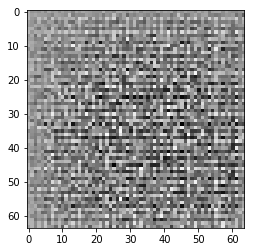

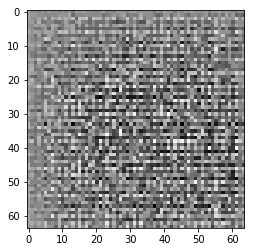

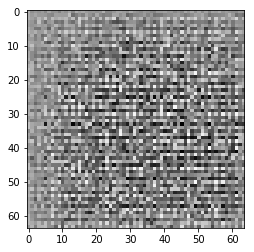

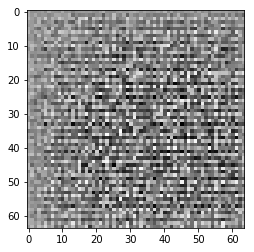

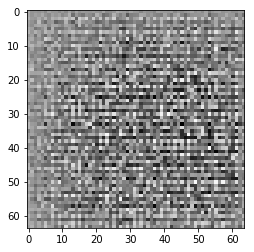

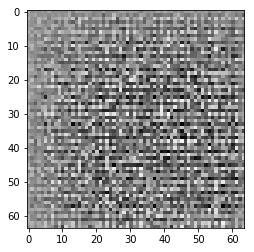

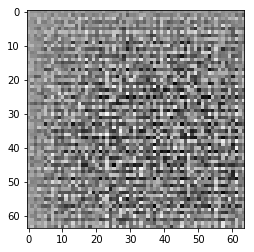

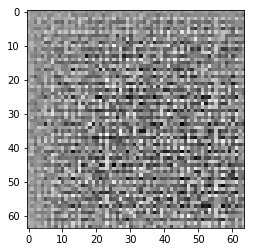

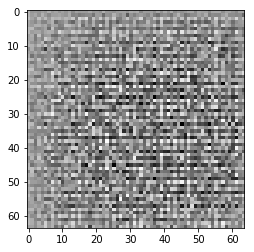

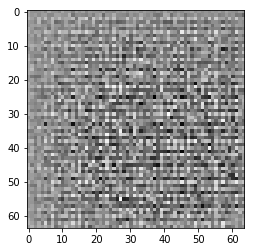

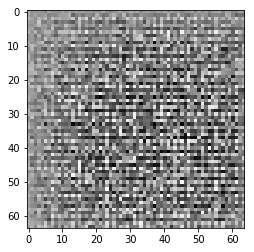

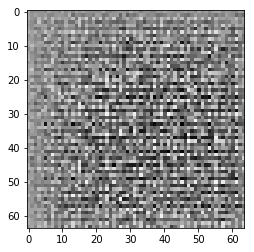

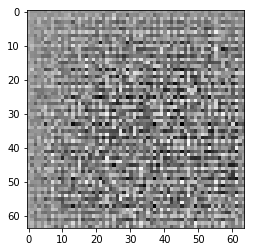

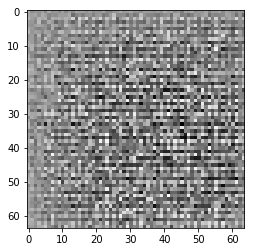

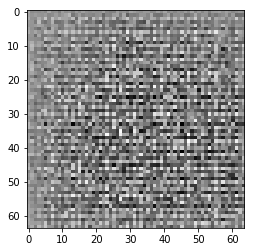

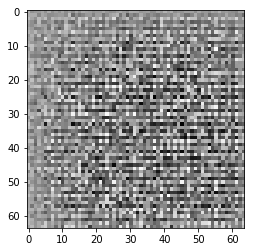

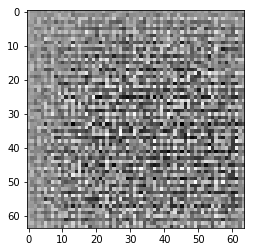

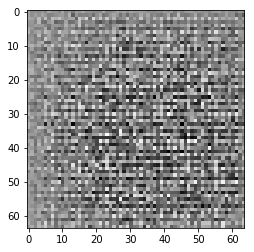

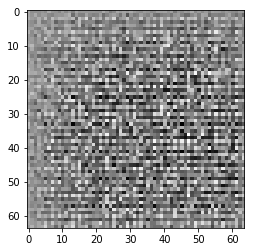

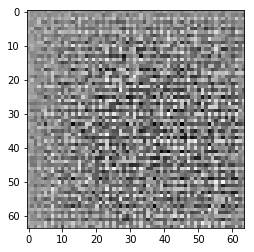

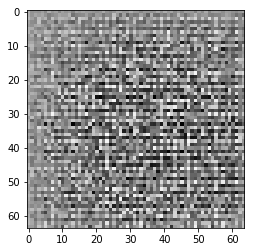

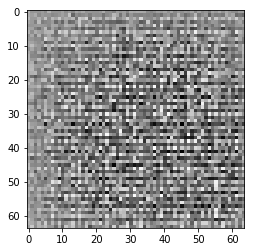

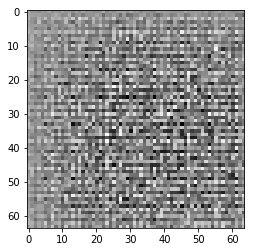

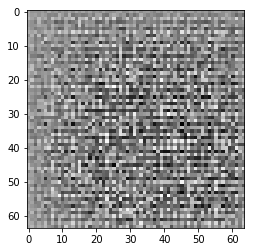

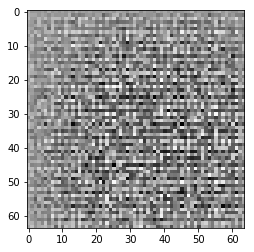

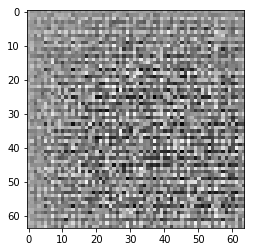

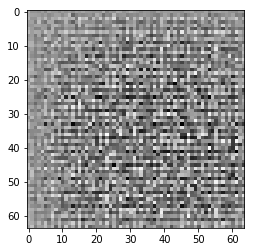

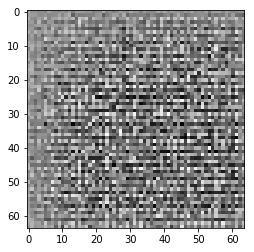

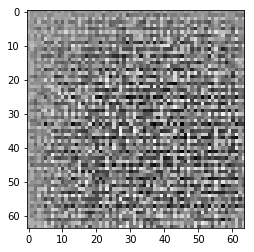

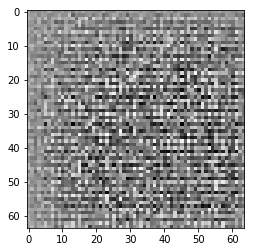

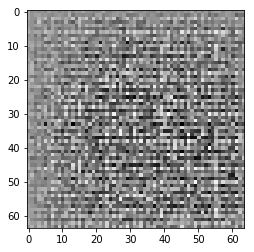

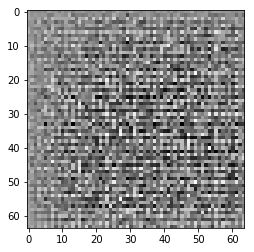

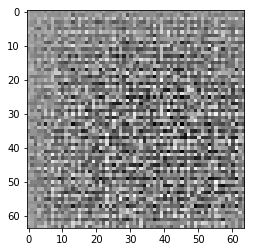

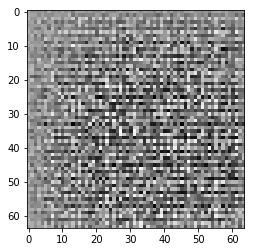

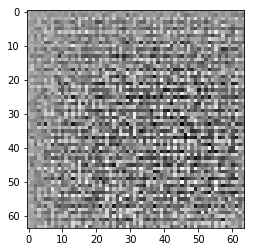

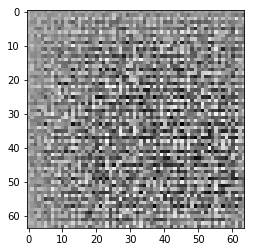

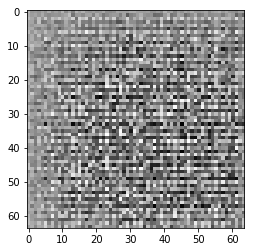

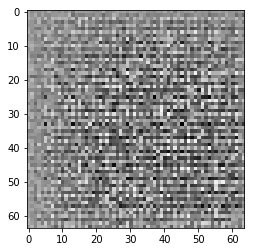

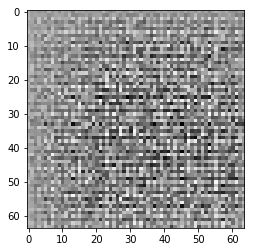

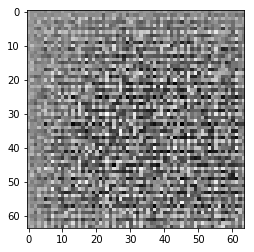

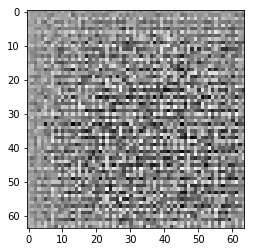

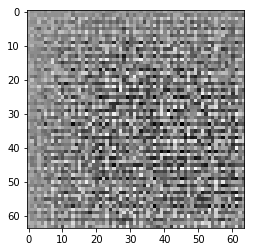

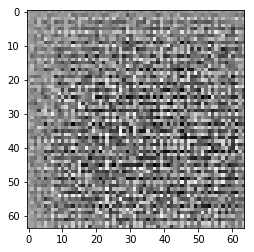

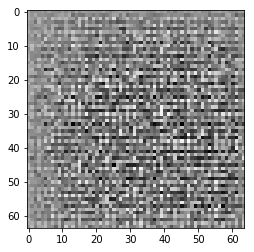

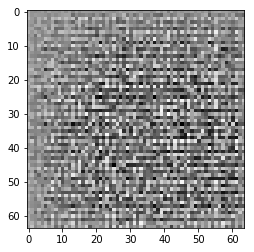

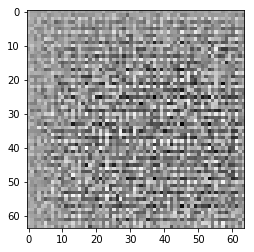

In [6]:
######UNIT TEST FOR GENERATOR#############
def GeneratorTest(sess):
    input_noises = np.random.random_sample((batch_size, 30))
    #print(input_noises)   
    fake_images = Generator(tf.convert_to_tensor(input_noises, dtype = tf.float32), name = "G_unit_test")
    tf.global_variables_initializer().run()
    print(fake_images)

    result = sess.run(fake_images)

    # To interpret the values as a 28x28 image, we need to reshape
    # the numpy array, which is one dimensional.
    figs = []
    for i in range(batch_size):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.imshow(result[i].reshape(image_size, image_size), cmap=plt.cm.Greys)
        figs.append(fig)
    print("Generator test is passed")

def DiscriminatorTest(sess):
    images = training_dataset[100: 100+batch_size]
    authenticities = Discriminator(tf.convert_to_tensor(images, dtype = tf.float32), name = "D_unit_test")
    tf.global_variables_initializer().run()
    print("fake_images shape:", authenticities)
    a = sess.run(authenticities)
    print("a:", a)
    print("loss:", 1-a)
    print("Discriminator test is passed")
    
def UnitTest():
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
    sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
    sess.as_default()
    
    GeneratorTest(sess)
    DiscriminatorTest(sess)
    sess.close()
UnitTest()

# GAN

In [7]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
sess.as_default()

# D network
true_images = tf.placeholder(tf.float32, shape = (batch_size, image_size, image_size, 1))
D_logits = Discriminator(true_images, name = "Dis")

# GD network
GD_input_node = tf.placeholder(tf.float32, shape = (batch_size, noise_length+1))
fake_images = Generator(GD_input_node, name = "Gen")
fake_images_sum = tf.summary.image('fake_images', fake_images)
GD_logits = Discriminator(fake_images, name = "Dis", reuse = True)

# loss of the discriminator
# D will try to minimize loss_S_true-loss_S_fake
# D_a: how likely a true image is true
# 1-GD_a: how likely a fake image is fake
TINY = 1e-6 #help NaN. inspired by info-gan implementation
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logits,  labels = tf.ones_like(D_logits)))
tf.summary.scalar('d_loss_real', d_loss_real)
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = GD_logits, labels = tf.zeros_like(GD_logits)))
tf.summary.scalar('d_loss_fake', d_loss_fake)
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = GD_logits, labels = tf.ones_like(GD_logits)))
tf.summary.scalar('g_loss', g_loss)

d_loss = d_loss_real + d_loss_fake
tf.summary.scalar("d_loss", d_loss)
# only train D in D_optimizer
D_train_vars = [var for var in tf.trainable_variables() if 'Dis' in var.name]
print(D_train_vars)
D_optimizer = tf.train.AdamOptimizer(learning_rate=0.0002, 
                                     beta1 = 0.5, 
                                     beta2 = 0.999).minimize(d_loss, var_list = D_train_vars)
# only train G in G_optimizer

G_train_vars = [var for var in tf.trainable_variables() if 'Gen' in var.name]
print(G_train_vars)
GD_optimizer = tf.train.AdamOptimizer(learning_rate=0.0002, 
                                     beta1 = 0.5, 
                                     beta2 = 0.999).minimize(g_loss, var_list = G_train_vars)

merged = tf.summary.merge_all()
g_sum = tf.summary.merge([fake_images_sum])
# auto increment train id
i = 0
while os.path.exists(directory+"/train%s" % i):
    i += 1
train_writer = tf.summary.FileWriter(directory + '/train'+str(i),
                                      sess.graph)
# saver
saver = tf.train.Saver()
tf.global_variables_initializer().run()

[<tf.Variable 'Dis/conv0/weights:0' shape=(5, 5, 1, 64) dtype=float32_ref>, <tf.Variable 'Dis/conv0/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Dis/conv1/weights:0' shape=(5, 5, 64, 128) dtype=float32_ref>, <tf.Variable 'Dis/conv1/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'Dis/conv1/batch_norm/BatchNorm/beta:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'Dis/conv1/batch_norm/BatchNorm/gamma:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'Dis/conv2/weights:0' shape=(5, 5, 128, 256) dtype=float32_ref>, <tf.Variable 'Dis/conv2/biases:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'Dis/conv2/batch_norm/BatchNorm/beta:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'Dis/conv2/batch_norm/BatchNorm/gamma:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'Dis/conv3/weights:0' shape=(3, 3, 256, 512) dtype=float32_ref>, <tf.Variable 'Dis/conv3/biases:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'Dis/conv3/batch_norm/BatchNorm/beta:0' shape=(512,) dtype=float3

In [8]:
# print_variable()
print(fake_images)

Tensor("Gen/output/Tanh:0", shape=(100, 64, 64, 1), dtype=float32)


In [9]:
figs = []
for step in range(1000):
    offset = (step * batch_size) % (train_size - batch_size)
    batch_data = training_dataset[offset:batch_size+offset]
    batch_labels = training_label[offset:batch_size+offset].reshape((batch_size, 1))
    
    batch_z = np.random.uniform(-1, 1, (batch_size, noise_length+1)) \
              .astype(np.float32)

    _D, loss_d, summary = sess.run(
      [D_optimizer, d_loss, merged],
      feed_dict={GD_input_node: batch_z,
                 true_images: batch_data})
    train_writer.add_summary(summary, step)
    #flip true/false label when train GD
    _GD, loss_g, summary= sess.run(
      [GD_optimizer, g_loss, g_sum],
      feed_dict={GD_input_node: batch_z})
    train_writer.add_summary(summary, step)
    _GD, loss_g, summary= sess.run(
      [GD_optimizer, g_loss, g_sum],
      feed_dict={GD_input_node: batch_z})
    train_writer.add_summary(summary, step)
    if step % 50 ==0:
        print(step)
        save_path = saver.save(sess, directory+str(step)+".ckpt")


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
